In [3]:
import py4DSTEM
import time
import numpy as np
from py4DSTEM.visualize import show

#timestr = time.strftime("%Y%m%d")
timestr = '20240814' # in case you want to use older data/not preprocess everything again

py4DSTEM.__version__

'0.14.15'

In [4]:
# Load the .dm4 file from a workspace on OMNI or XNAS, set filepath with 'filepath_data = "FILEPATH"'
dirpath = "/fast/ws-tmp/g031362-data/high_pressure_torsion/lamC/ROI3/"

filepath_data = dirpath + 'COPL_Ni65Cu35_C_ROI3_240827_aper_50_conv_1.5_spot_6_CL_47_stepsize_10_r_x_178_r_y_186_GIF_512x512_preprocessed_unfiltered_no_bin.h5'
filepath_basics_01 = dirpath + 'analysis_basics_01.h5'
filepath_basics_02 = dirpath + 'analysis_basics_02.h5'
filepath_basics_03 = dirpath + 'analysis_basics_03.h5'


filepath_cif = dirpath + 'CuNi.cif'

In [5]:
py4DSTEM.print_h5_tree(filepath_data)

/
|---dm_dataset_root
    |---dm_dataset




In [6]:
# Load the datacubes using py4DSTEM
dataset = py4DSTEM.read(
    filepath_data,
    root='dm_dataset_root/dm_dataset',
)

# Virtual imaging

In [7]:
dataset.get_dp_max()
dataset.get_dp_mean()

VirtualDiffraction( A 2-dimensional array of shape (512, 512) called 'dp_mean',
                    with dimensions:

                        dim0 = [0,1,2,...] pixels
                        dim1 = [0,1,2,...] pixels
)

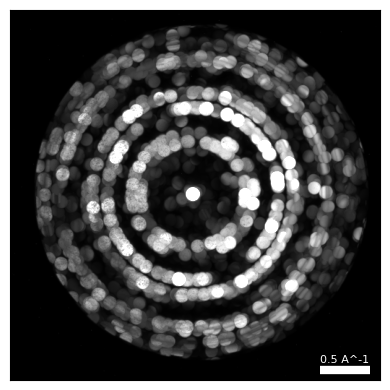

In [8]:
py4DSTEM.visualize.show(
    dataset.tree('dp_max'),
    figsize = (4,4),
    ticks = False,
)

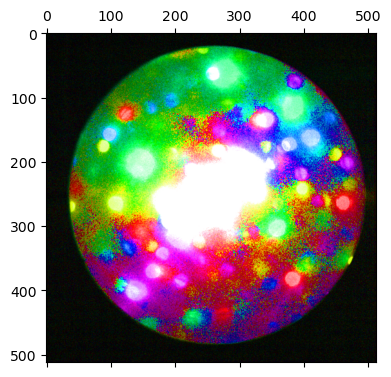

In [9]:
py4DSTEM.show(
    [
        dataset.data[20,20],
        dataset.data[60,20],
        dataset.data[20,70],
        dataset.data[50,45],
        dataset.data[9,7],
    ],
    combine_images=True,
    figsize = (4,4),
)

Estimated probe radius = 9.34 pixels


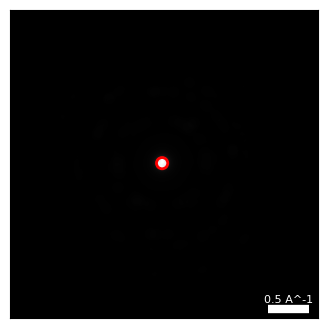

In [10]:
# Estimate the radius of the BF disk, and the center coordinates
probe_semiangle, probe_qx0, probe_qy0 = dataset.get_probe_size(
    dataset.tree('dp_mean').data,
)
center = (probe_qx0, probe_qy0)

# plot the mean diffraction pattern, with the estimated probe radius overlaid as a circle
fig, ax = py4DSTEM.show(
    dataset.tree('dp_mean'),
    figsize=(4,4),
    circle = {
        'center': center,
        'R': probe_semiangle,
    },
    ticks = False,
    returnfig = True,
    vmax = 1,
);
# ax.set_xlim([57, 70]);
# ax.set_ylim([70, 57]);

# Print the estimate probe radius
print('Estimated probe radius =', '%.2f' % probe_semiangle, 'pixels')

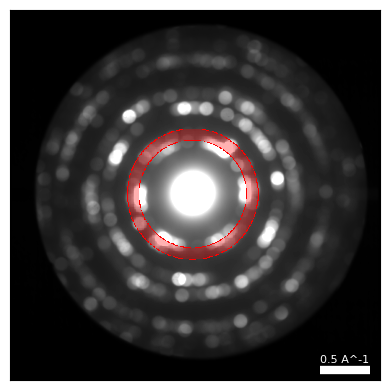

100%|███████████████████████████████████████████████████████████| 33108/33108 [00:05<00:00, 6076.43it/s]


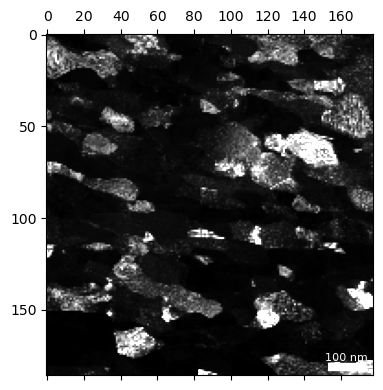

In [11]:
# Create a virtual annular dark field (ADF) image around the first diffraction ring

radii = (75,90)

# Plot the ADF detector
dataset.position_detector(
    mode = 'annular',
    geometry = (
        center,
        radii
    ),
    figsize = (4,4),
    ticks = False,
)

# Calculate the ADF image
dataset.get_virtual_image(
    mode = 'annulus',
    geometry = (center,radii),
    name = 'dark_field',
)

# Plot the ADF image
py4DSTEM.show(
    dataset.tree('dark_field'),
    figsize = (4,4),
)

# Probe template

In [12]:
# Load the prior analysis

basics_03 = py4DSTEM.read(
    filepath_basics_03
)

basics_03.tree()

Reading PointListArray: 100%|████████████████████████████| 33108/33108 [00:05<00:00, 6469.22PointList/s]

/
|---2Dhist_braggvectors_cal_s=8
|---braggvectors
|---probe


In [13]:
probe = basics_03.tree('probe')

probe

Probe( A stack of 2 Arrays with 2-dimensions and shape (512, 512), called 'probe'

       The labels are:
           probe
           kernel


       The Array dimensions are:
           dim0 = [0,1,2,...] pixels
           dim1 = [0,1,2,...] pixels
)

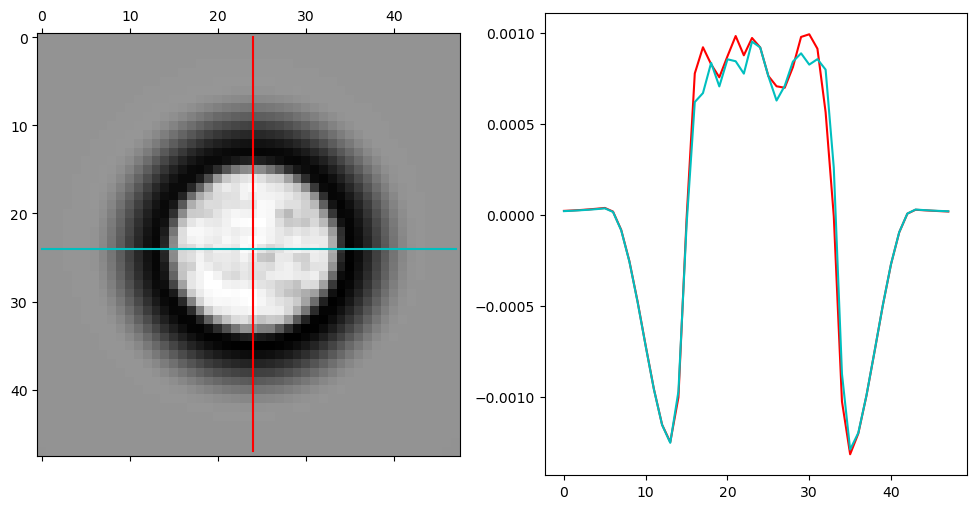

In [15]:
py4DSTEM.visualize.show_kernel(
    probe.kernel,
    R = 24,
    L = 24,
    W = 1
)

# Bragg disk detection

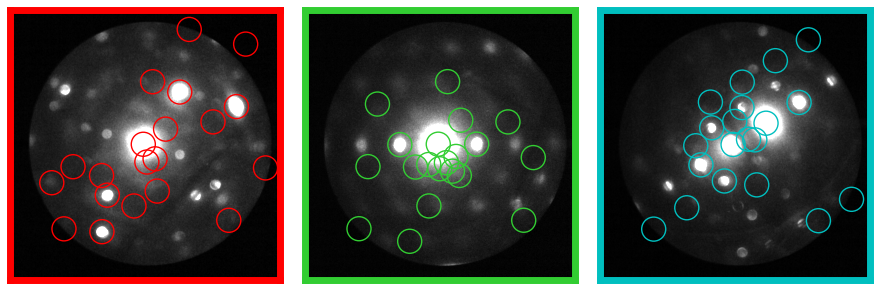

In [17]:
# Test parameters on a few probe positions
# Visualize the diffraction patterns and the located disk positions

rxs = 60,60,45
rys = 60,40,36
colors=['r','limegreen','c']


detect_params = {
    'minAbsoluteIntensity': 8,   # intensity threshold
    'minRelativeIntensity': 0,   # int. thresh. relative to brightest disk in each pattern
    'minPeakSpacing': 11,         # if two peaks are closer than this (in pixels), remove the dimmer peak
    'edgeBoundary': 2,           # remove peaks within this distance of the edge of the diffraction pattern
    'sigma': 0.4,                  # gaussian blur size to apply to cross correlation before finding maxima
    'maxNumPeaks': 20,          # maximum number of peaks to return, in order of intensity
    'subpixel' : 'poly',         # subpixel resolution method
    'corrPower': 1.0,            # if <1.0, performs a hybrid cross/phase correlation. More sensitive to edges and to noise
#     'CUDA': True,              # if a GPU is configured and cuda dependencies are installed, speeds up calculation 
}



disks_selected = dataset.find_Bragg_disks(
    data = (rxs, rys),
    template = probe.kernel,
    **detect_params,
)

py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:dataset.data[rxs[i],rys[i],:,:],
    H=1, 
    W=3,
    axsize=(3,3),
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 300,
)

In [18]:
# Find Bragg peaks for all probe positions
bragg_peaks = dataset.find_Bragg_disks(
    template = probe.kernel,
    **detect_params,
)

Finding Bragg Disks: 100%|█████████████████████████████████████████| 33.1k/33.1k [11:43<00:00, 47.1DP/s]


# Centering and calibration

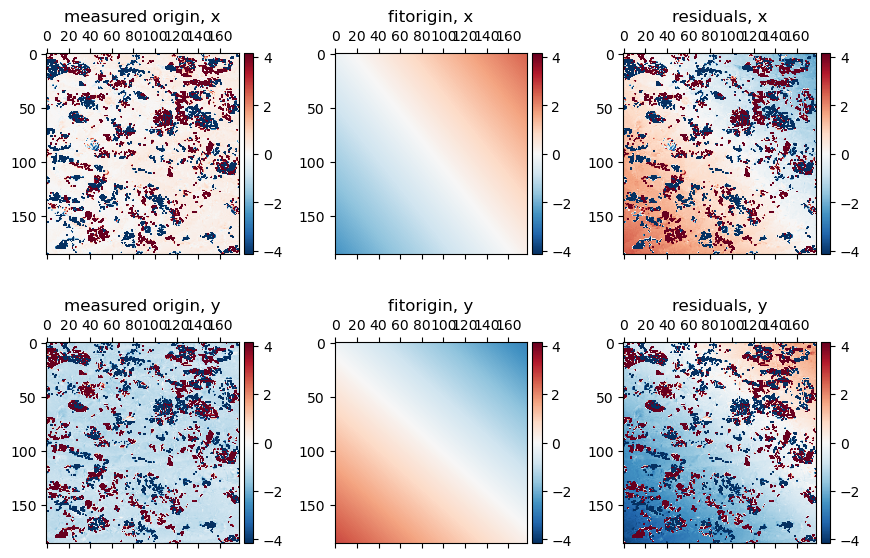

In [19]:
# Compute the origin position for all probe positions by finding and then fitting the center beam

# measure origins
qxy_origins = bragg_peaks.measure_origin(
    # mode = 'no_beamstop',
)

# fit a plane to the origins
qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = bragg_peaks.fit_origin(
    # plot_range=0.1,
    figsize = (4,4)
)

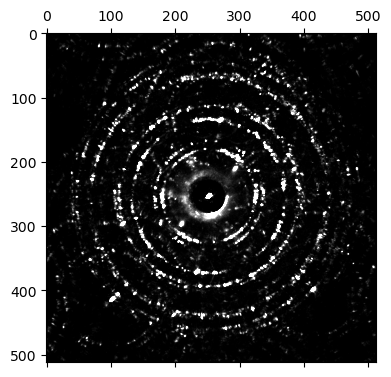

In [20]:
# Calculate BVM from centered data
bragg_vector_map_centered = bragg_peaks.get_bvm()

py4DSTEM.show(
    bragg_vector_map_centered,
    figsize = (4,4),
)

# Pixel size calibration

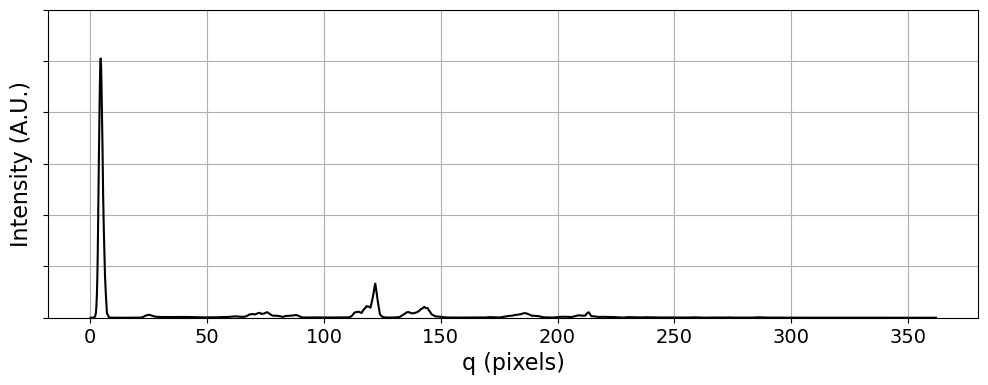

In [24]:
# Calculate and plot the radial integral.
# Note that for a 2D material, the center beam is orders of magnitude higher than the diffracted beam.
# Thus we need to specify a maximum y value for the plot.
# We also scale the plotted intensity by q to better show the higher angle peaks.
ymax = 6e10


q, intensity_radial = py4DSTEM.process.utils.radial_integral(
    bragg_vector_map_centered,
)

py4DSTEM.visualize.show_qprofile(
    q = q,
    intensity = intensity_radial * q,
    ymax = ymax,
)

In [25]:
# Load the WS2 crystal file
crystal = py4DSTEM.process.diffraction.Crystal.from_CIF(filepath_cif)

get_structures is deprecated; use parse_structures in pymatgen.io.cif instead.
The only difference is that primitive defaults to False in the new parse_structures method.So parse_structures(primitive=True) is equivalent to the old behavior of get_structures().


In [26]:
# Calculate structure factors
k_max = 1.4

crystal.calculate_structure_factors(
    k_max,
)

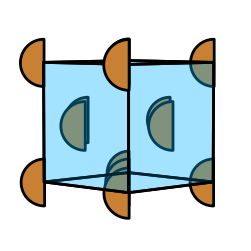

In [27]:
crystal.plot_structure(
    zone_axis_lattice=(1,1,0.1),
    figsize=(6,3),   
    camera_dist = 6,
)

(0.0, 1.4)

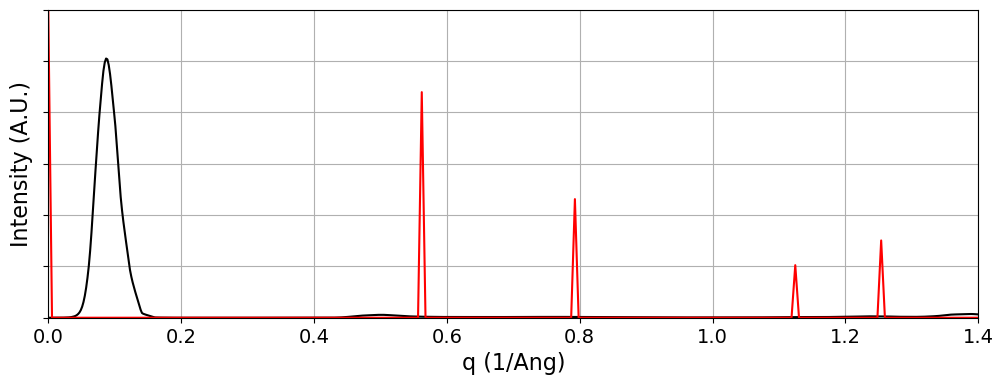

In [28]:
# Test different pixel sizes, and overlay the structure factors onto the experimental data.

inv_Ang_per_pixel = 0.02

q_SF = np.linspace(0,k_max,250)
I_SF = np.zeros_like(q_SF)
for a0 in range(crystal.g_vec_leng.shape[0]):
    if np.abs(crystal.g_vec_all[2,a0]) < 0.01:
        idx = np.argmin(np.abs(q_SF-crystal.g_vec_leng[a0]))
        I_SF[idx] += crystal.struct_factors_int[a0]
I_SF /= np.max(I_SF)

fig,ax = py4DSTEM.visualize.show_qprofile(
    q=q*inv_Ang_per_pixel,
    intensity=intensity_radial*q,
    xlabel='q (1/Ang)',
    returnfig=True,
    ymax=ymax,
)

ax.plot(q_SF,I_SF*ymax,c='r')
ax.set_xlim([0, k_max])

In [29]:
# Apply pixel size calibration
bragg_peaks.calibration.set_Q_pixel_size(inv_Ang_per_pixel)
bragg_peaks.calibration.set_Q_pixel_units('A^-1')

In [30]:
bragg_peaks.calstate

{'center': True, 'ellipse': False, 'pixel': True, 'rotate': False}

In [31]:
# Save calibrated Bragg peaks
filepath_braggdisks_cal = dirpath + 'braggdisks_cal.h5'
py4DSTEM.save(
    filepath_braggdisks_cal,
    bragg_peaks,
    mode='o',
)

100%|███████████████████████████████████████████████████████████| 33108/33108 [00:03<00:00, 8973.56it/s]


# Automated crystal orientation mapping (ACOM)

In [32]:
# Reload Bragg peaks if needed
filepath_braggdisks_cal = dirpath + 'braggdisks_cal.h5'
py4DSTEM.print_h5_tree(filepath_braggdisks_cal)

/
|---dm_dataset_root
    |---braggvectors
        |---_v_uncal




In [33]:
# Reload bragg peaks cif file, recompute structure factors
bragg_peaks = py4DSTEM.read(
    filepath_braggdisks_cal, 
)
bragg_peaks

k_max = 1.4
crystal = py4DSTEM.process.diffraction.Crystal.from_CIF(filepath_cif)
crystal.calculate_structure_factors(
    k_max,
)

Reading PointListArray: 100%|████████████████████████████| 33108/33108 [00:05<00:00, 6194.29PointList/s]
get_structures is deprecated; use parse_structures in pymatgen.io.cif instead.
The only difference is that primitive defaults to False in the new parse_structures method.So parse_structures(primitive=True) is equivalent to the old behavior of get_structures().


In [34]:
# Create an orientation plan for [0001] WS2
crystal.orientation_plan(
    angle_step_zone_axis = 1.0,
    angle_step_in_plane = 4.0,
    zone_axis_range = 'fiber',
    fiber_axis = [0,0,1],
    fiber_angles = [0,0],
#     CUDA=True,
)

Orientation plan: 100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 1462.96 zone axes/s]


No good match found for index 0


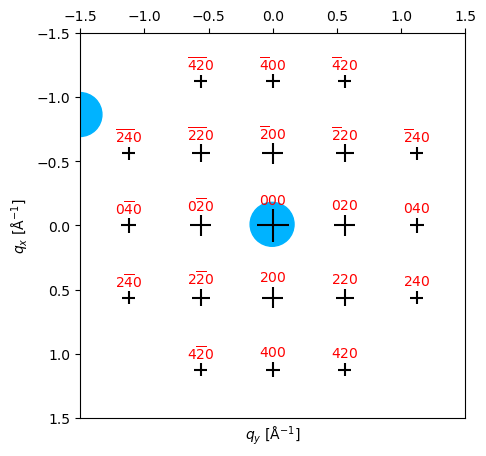

In [35]:
# Test matching on some probe positions
xind, yind = 20,64
#xind, yind= 32,96

orientation  = crystal.match_single_pattern(
    bragg_peaks.cal[xind,yind],
#     plot_corr = True,
#     plot_polar = False,
    verbose = True,
)

sigma_compare = 0.03
range_plot = np.array([k_max+0.1,k_max+0.1])

bragg_peaks_fit = crystal.generate_diffraction_pattern(
    orientation,
    ind_orientation=0,
    sigma_excitation_error=sigma_compare)


# plot comparisons
py4DSTEM.process.diffraction.plot_diffraction_pattern(
    bragg_peaks_fit,
    bragg_peaks_compare=bragg_peaks.cal[xind,yind],
    scale_markers=1000,
    scale_markers_compare=4e4,
    plot_range_kx_ky=range_plot,
    min_marker_size=1,
    figsize = (5,5),
)

In [36]:
# Fit orientation to all probe positions
orientation_map = crystal.match_orientations(
    bragg_peaks,
)

bragg peaks not rotationally calibrated
Matching Orientations: 100%|████████████████████████████| 33108/33108 [00:15<00:00, 2078.74 PointList/s]


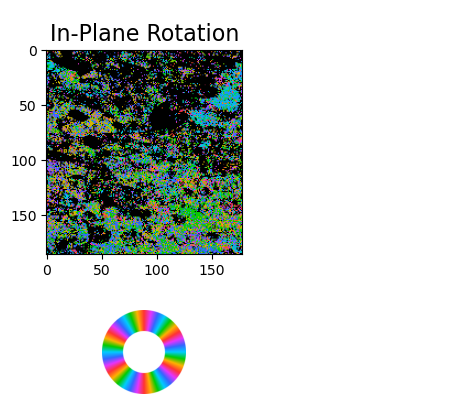

In [38]:
# Plot the orienations 
images_orientation = crystal.plot_fiber_orientation_maps(
    orientation_map,
    symmetry_order = 6,
    corr_range = [0.9, 1.0],
    figsize = (4,4),
)

# Strain maps 

For each diffraction pattern, we have both the measured diffraction pattern Bragg peaks, and the Bragg peaks calculated from the best-fit orientation. We can therefore directly calculate a strain map, just by measuring the best-fit transformation tensor between these two sets of peaks.

In [39]:
strain_map = crystal.calculate_strain(
    bragg_peaks,
    orientation_map,
    rotation_range=np.pi/3, # 60 degrees
#     corr_kernel_size=0.02,
)

bragg peaks not elliptically calibrated
bragg peaks not rotationally calibrated
Calculating strains:   2%|▋                               | 759/33108 [00:00<00:25, 1262.11 PointList/s]Mean of empty slice.
invalid value encountered in scalar divide
Calculating strains: 100%|██████████████████████████████| 33108/33108 [00:26<00:00, 1257.65 PointList/s]


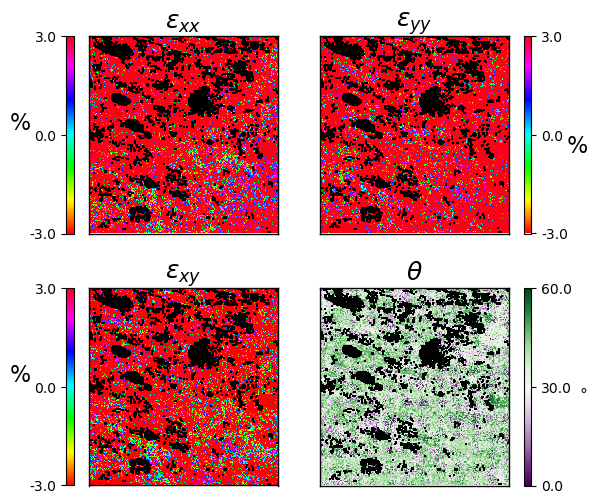

In [40]:
# plot the 4 components of the strain tensor
fig,ax = py4DSTEM.visualize.show_strain(
    strain_map,
    vrange_exx=[-3.0, 3.0],
    vrange_theta=[0.0, 60.0],
    ticknumber=3,
    # axes_plots=(),
    # bkgrd=False,
    figsize=(6,6),
    cmap='hsv',
    returnfig=True
)